<a href="https://colab.research.google.com/github/JinseongP/Basic-AI/blob/main/ML/2_1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장 모델 훈련

## 주요 내용

- 경사 하강법
- 모델 규제
- 로지스틱 회귀/소프트맥스 회귀

__참고:__
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

## 4.1 선형 회귀 (p. 158)

아래 코드는 선형 회귀 학습 과정을 설명하기 위해 사용되는 하나의 특성을 사용하는
간단한 훈련 데이터를 생성한다.

* `X`: 훈련 세트. 하나의 특성 `x1`을 갖는 100개의 데이터
* `y`: 100 개의 레이블. 기본적으로 `4 + 3 * x`의 형식을 따르나 훈련을 위해 잡음(noise)를 추가 했음.

__참고:__ 정규분포를 따르는 부동소수점 100개를 무작위로 생성하여 잡음으로 사용하였다.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [3]:
linreg_data = np.c_[X, y]

In [4]:
linreg_data[:5]

array([[0.74908024, 6.33428778],
       [1.90142861, 9.40527849],
       [1.46398788, 8.48372443],
       [1.19731697, 5.60438199],
       [0.31203728, 4.71643995]])

특성 `x1`과 레이블 `y`의 관계를 그리면 다음과 같다.
기본적으로 `y = 4 + 3 * x` 의 선형관계를 갖지만 잡음으로 인해 데이터가 퍼져 있다.

그림 저장: generated_data_plot


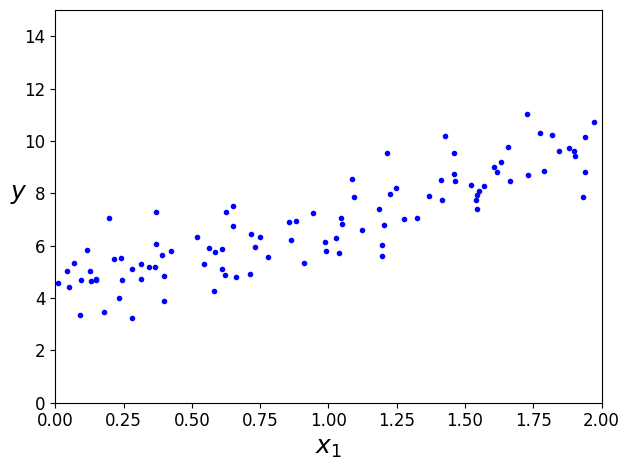

In [5]:
plt.plot(X, y, "b.")                          # 파랑 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)              # x축 표시
plt.ylabel("$y$", rotation=0, fontsize=18)    # y축 표시
plt.axis([0, 2, 0, 15])                       # x축, y축 구간 지정

save_fig("generated_data_plot")
plt.show()

### 4.1.1 정규 방정식 (p. 160)

일반적으로 $n$개의 특성을 갖는 임의의 크기의 데이터셋 `X`가 주어졌을 때,
$(\mathbf{X}^T \mathbf{X})^{-1}$의 역행렬이 존재하고 실제로 일정 시간 내에 계산이 가능하다면 최적의
파라미터 조합 $\boldsymbol{\hat\theta}$ 를 아래 정규 방정식으로 직접 구할 수 있다.

$$
\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

아래 코드는 위 정규 방정식을 위에서 생성한 훈련 세트에 대해 계산한다.

* `np.ones((100, 1))`: 절편 $\theta_0$를 고려하기 위해 훈련세트의 0번 열에 추가되는 `x0=1`로 이루어진 벡터
* `X_b`: 모든 샘플에 대해 `x0=1`이 추가된 어레이

__주의사항:__ 1 벡터를 추가하는 일은 여기서만 설명을 위해 사용된다.
사이킷런의 모델을 사용할 때는 모델이 알아서 처리해준다.

In [6]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1 추가
X_b[:5]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728]])

In [7]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

계산된 $\boldsymbol{\hat\theta} = [\theta_0, \theta_1]$ 은 다음과 같다.

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

계산된 $\boldsymbol{\hat\theta}$ 를 이용하여 `x1=0`과 `x1=2`일 때의 예측값 $\hat y$는 단순한 행렬 곱셈에 불과하다.

$$\hat{y} = \mathbf{X}\, \boldsymbol{\hat{\theta}}$$

예측을 위해서도 먼저 `x0=1` 열을 추가해야 한다.

__주의사항:__ $\mathbf{X}$ 와 $\hat\theta$ 의 순서에 너무 민감해할 필요는 없다.
설명하는 방식에 따라 순서가 바뀌거나 전치행렬이 사용될 뿐이며, 결과는 모두 동일하다.

In [9]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1 추가
X_new_b

array([[1., 0.],
       [1., 2.]])

행렬 곱셈에 의한 예측값은 다음과 같다.

In [10]:
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

$\theta_0$ 을 절편으로, $\theta_1$ 을 기울기로 하는 직선은 아래와 같다.

그림 저장: linear_model_predictions_plot


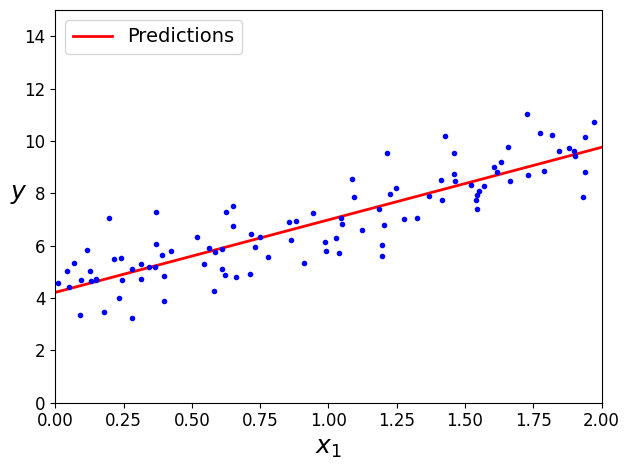

In [11]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions") # 빨강 직선. label은 범례 지정용

plt.plot(X, y, "b.")                                               # 파란 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.legend(loc="upper left", fontsize=14)                          # 범례 위치
plt.axis([0, 2, 0, 15])                                            # x축, y축 구간 지정

save_fig("linear_model_predictions_plot")
plt.show()

### 사이킷런의 `LinearRegression` 모델

`LinearRegression` 모델은 특잇값 분해(SVD) 방식을 이용하여 계산된 무어-펜로즈의 유사 역행렬 $\mathbf{X}^+$를
이용하여 파라미터 $\hat\theta$를 계산한다.

$$
\hat{\boldsymbol{\theta}} = \mathbf{X}^+ \mathbf{y}
$$

훈련된 모델의 `intercept_`와 `coef_` 속성에 절편 $\theta_0$ 과 기울기 $\theta_1$ 이 저장된다.

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

`x1=0`과 `x1=2`에 대한 예측값과 앞서 수동으로 계산된 값과 동일하다.

In [13]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

## 4.3 다항 회귀 (p.177)

아래 코드는 무작위로 100개의 훈련 데이터를 생성한다.
한 개의 특성만 사용하며 타깃은 아래 2차 다항식으로 생성한 다음에 잡음을 추가한다.

$$y = 0.5\cdot x_1^2 + 2$$

__주의사항:__ 여기서 2차 함수를 이용하여 타깃을 계산하였지만 이는 단순히 예제를 위해서이다.
일반적으로는 특성과 타깃 사이에 어떤 연관성이 있는지 미리 알 수 없다는 것을 염두해야 한다.

In [14]:
import numpy as np

np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

훈련 세트의 산점도는 다음과 같다.

그림 저장: quadratic_data_plot


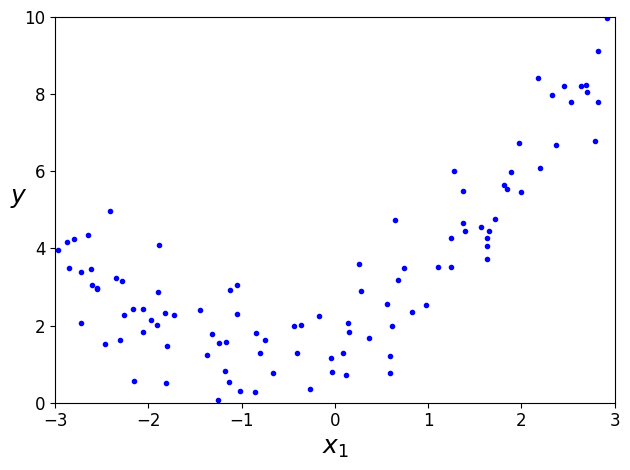

In [15]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

선형 회귀 모델을 바로 적용하면 좋은 모델을 얻을 수 없다.
따라서 다항 회귀 기법을 사용하여 보다 좋은 모델을 훈련시킬 수 있는지 확인하려 한다.

아래 코드는 2차 다항 회귀 변환기 이용하여 하나의 특성 `x1`을 갖는 데이터를
`x1`과 `x1**2`두 개의 특성을 갖는 데이터로 변환하는 것을 보여준다.

* `PolynomialFeatures`: 다항 회귀 변환기
* `degree=2`: 2차 다항식을 활용하라고 지정하기. 3, 4, 등 임의의 양의 정수를 사용할 수 있음.
* `include_bias=False`: 절편(편향)을 변환된 어레이에 추가할지 여부 지정. 기본값은 `True` 이지만
    여기서는 사용하지 않음. 이유는 변환된 어레이를 `LinearRegression()` 모델에서
    사용할 예정이며, 거기서 입력 어레이는 편향을 사용하지 않기 때문임.

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

첫째 훈련 데이터는 원래 특성 $x_1$만 갖는다.

In [17]:
X[0]

array([-0.75275929])

반면에 변환된 첫째 훈련 데이터는 두 개의 특성 $x_1, x_1^2$ 를 갖는다.

In [18]:
X_poly[0]

array([-0.75275929,  0.56664654])

변환된 데이터를 이용하여 선형 회귀 모델을 학습시킨다.

In [19]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

학습된 모델의 절편과 기울기는 다음과 같다.

__참고:__ 2차 다항 회귀 모델을 적용하기 위해 변환된 데이터는
절편에 대한 파라미터 $\theta_0$와 두 개의 특성 $x_1$과 $x_1^2$ 각각에 대한 파라미터
$\theta_1$과 $\theta_2$를 갖는다.

In [20]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

아래 코드는 새로운 샘플 100개에 대해 앞서 훈련시킨 다항 회귀 모델을 이용하여 예측을 수행한 후
예측 결과를 그래프로 그린다.

그림 저장: quadratic_predictions_plot


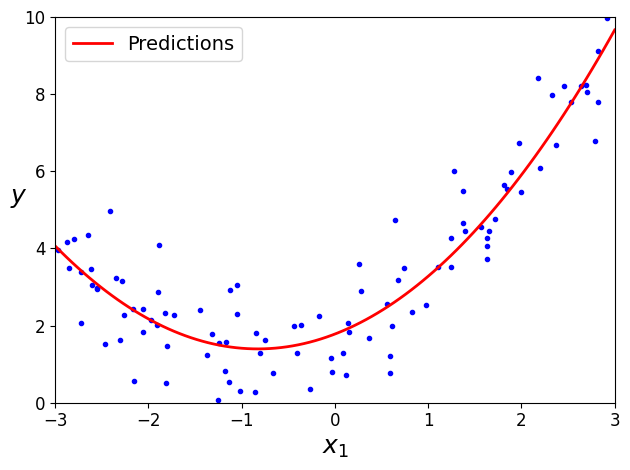

In [21]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)     # 새로운 샘플 100개
X_new_poly = poly_features.transform(X_new)       # 2차 다항 회귀 모델 데이터로 변환
y_new = lin_reg.predict(X_new_poly)               # 예측하기

plt.plot(X, y, "b.")                                            # 기존 데이터 산점도
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")  # 예값 그래프

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

## 4.4 학습 곡선 (p. 179)

아래 코드는 아래 세 모델을 사용하여 얻어진 예측값을 비교한다.

* 초록 실선 그래프: 300차 다항 회귀 모델
* 파랑 파선 그래프: 2차 다항 회귀 모델
* 빨강 철망 그래프: 1차 선형 회귀 모델

그림 저장: high_degree_polynomials_plot


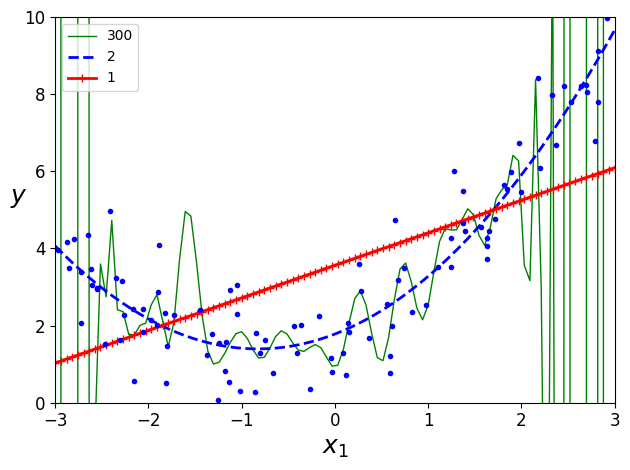

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 세 개의 다항 회귀 모델 지정: 차례 대로 300차 다항 회귀, 2차 다항 회귀, 1차 선형 회귀 모델의 예측값 그래프 그리기
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):

    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)  # 다항 특성 변환기
    std_scaler = StandardScaler()                                             # 표준화 축척 조정
    lin_reg = LinearRegression()                                              # 선형 회귀 모델

    polynomial_regression = Pipeline([                         # 파이프라인: 전처리 + 선형 회귀 모델
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])

    polynomial_regression.fit(X, y)                                            # 훈련
    y_newbig = polynomial_regression.predict(X_new)                            # 예측

    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)       # 그래프 그리기

plt.plot(X, y, "b.", linewidth=3)                                              # 원 데이터 산점도
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

### 학습 곡선

훈련 세트와 검증 세트에 대한 모델 성능의 변화를 추적하는 곡선이 __학습 곡선__이다.
모델 성능의 변화는 훈련 세트의 크기를 1부터 시작해서 최대값까지 바꾸면서
훈련된 모델의 성능을 훈련 세트와 검증 세트 각각에 대해 측정하는 방식으로 확인한다.

아래 코드는 훈련 세트와 검증 세트에 대한 평균 제곱근 오차(RMSE)의 변화를 추적하는 그래프를 그린다.

* `plot_learning_curves()` 함수
    - `model`: 훈련에 사용되는 모델 지정
    - `X`: 8대 2 비율로 훈련 세트와 검증 세트로 분리되는 데이터 셋
    - `y`: 역시 8대 2 비율로 분리되는 레이블 셋.
    - 하는 일: 모델의 학습 곡선 그래프 그리기

In [23]:
from sklearn.metrics import mean_squared_error           # MSE 수동 계산
from sklearn.model_selection import train_test_split     # 무작위 샘플링

def plot_learning_curves(model, X, y):
    # 8:2 로 분류
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []                    # MSE 추적 장치

    for m in range(1, len(X_train)):                     # m 개의 훈련 샘플을 대상으로 훈련
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        # MSE 기록
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

#### 과소 적합 모델의 학습 곡선 특징

2차 다항식으로 생성된 데이터셋에 대한 선형 회귀 모델의 학습 곡선은 다음과 같으며,
전형적인 과소 적합의 양태를 잘 보여준다.

* 훈련 데이터(빨강)에 대한 성능
    * 훈련 세트가 커지면서 RMSE(평균 제곱근 오차)가 커짐
    * 훈련 세트가 어느 정도 커지면 더 이상 RMSE가 변하지 않음

* 검증 데이터(파랑)에 대한 성능
    * 검증 세트에 대한 성능이 훈련 세트에 대한 성능과 거의 비슷해짐

그림 저장: underfitting_learning_curves_plot


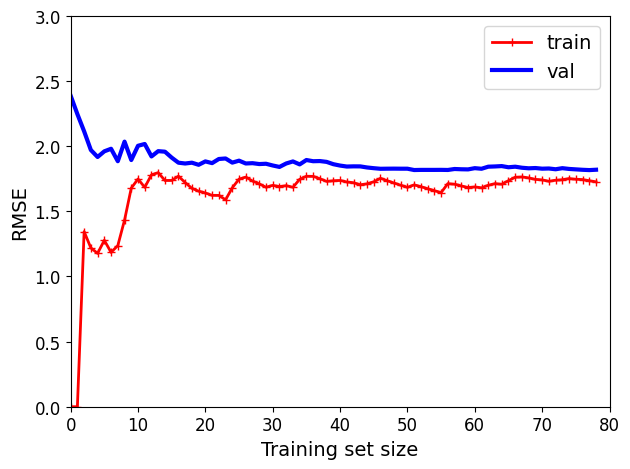

In [24]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

#### 과대 적합 모델의 학습 곡선 특징

2차 다항식으로 생성된 데이터셋에 대해 10차 다항 회귀를 적용한 선형 회귀 모델의 학습 곡선은 다음과 같으며,
전형적인 과대 적합의 양태를 잘 보여준다.

* 훈련 데이터(빨강)에 대한 성능: 훈련 데이터에 대한 평균 제곱근 오차가 매우 낮음.
* 검증 데이터(파랑)에 대한 성능: 훈련 데이터에 대한 성능과 차이가 크게 벌어짐.
* 과대적합 모델 개선법: 훈련 데이터 추가

그림 저장: learning_curves_plot


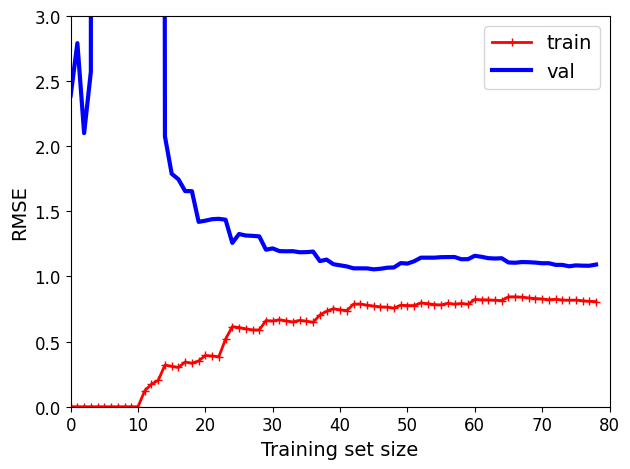

In [25]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # 책에는 없음
save_fig("learning_curves_plot")  # 책에는 없음
plt.show()                        # 책에는 없음